In [1]:
# this is demonstration for 3D from photo reconstruction
# https://github.com/3DTopia/OpenLRM

In [2]:
# TBD: download code, install libraries
# TBD: upload samples at google

In [3]:
# import libraries to preprocess image
from matplotlib import pyplot as plt
%matplotlib inline

import cv2
import numpy as np
import os.path
from PIL import Image
from rembg import remove

# this function crops source image to fit in 512x512 square window
def crop_512(img):
    img, alpha = img[:,:,:3], img[:,:,3]
    img.reshape(-1, 3)[alpha.reshape(-1)==0] = [255, 255, 255]
    x, y, w, h = cv2.boundingRect(alpha)
    img = img[y:y+h, x:x+w, :]

    if max(h, w) > 512:
        scale_factor = 412.0 / max(h, w)
        new_w, new_h = int(scale_factor * w), int(scale_factor * h)
        img = cv2.resize(img, (new_w, new_h))
        h, w = img.shape[:2]

    assert(max(h, w) <= 512)
    dh, dw = (512 - h) // 2, (512 - w) // 2
    img = np.pad(img, [(dh, 512 - dh - h), (dw, 512 - dw - w), (0, 0)], constant_values=255)

    # print(img.shape)
    # plt.imshow(img)
    # plt.show()
    assert (img.shape[0] == 512)
    assert (img.shape[1] == 512)
    return img

# this function removes background
def get_object(src_path: str, erosion_coeff=1.5) -> np.ndarray:
    if not os.path.exists(src_path):
        print(f"No such file or directory: {src_path}")
        return None
    with Image.open(src_path) as test:
        res = remove(test, False)
        res = np.asarray(res).copy()
        if erosion_coeff > 0:
            pix_size = int(erosion_coeff * max(res.shape[0], res.shape[1]) / 224)
            res[:,:,3] = cv2.erode(res[:,:,3], np.ones((2*pix_size+1, 2*pix_size+1)))
        return res

# this function loads and preprocess image to be used in reconstruction
def load_preprocessed(path):
    test = get_object(path)
    if test is not None:
        test = crop_512(test)
    return test

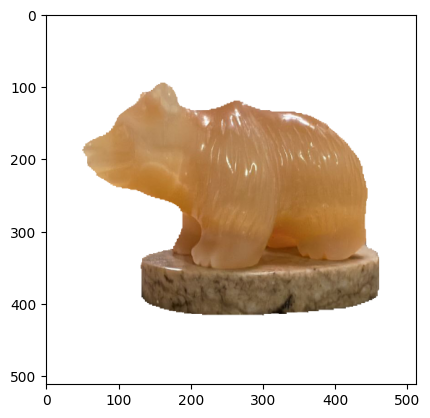

In [56]:
test = get_object("opal.jpg")#"/home/zipa/Pictures/Leonardo_Diffusion_XL_Year_of_a_green_wooden_dragon_1.webp" )
if test is not None:
    test = crop_512(test)
    plt.imshow(test)
    plt.show()

In [5]:
!cd lrm

In [6]:
!ls

assets	    LICENSE	    lrm		   preprocess_image.py	result.mov
demo.ipynb  LICENSE_NVIDIA  model_card.md  README.md		result.ply
dumps	    LICENSE_WEIGHT  points3D.ply   requirements.txt


In [57]:
# now we perform the reconstruction (code derived and reformed from lrm.inferrer)
import torch
from lrm.inferrer import LRMInferrer


def prepare_numpy(source_image: np.ndarray, source_image_size):
    image = torch.tensor(source_image).permute(2, 0, 1).unsqueeze(0) / 255.0
    # if RGBA, blend to RGB
    if image.shape[1] == 4:
        image = image[:, :3, ...] * image[:, 3:, ...] + (1 - image[:, 3:, ...])
    image = torch.nn.functional.interpolate(image, size=(source_image_size, source_image_size), mode='bicubic', align_corners=True)
    image = torch.clamp(image, 0, 1)
    return image

# this function repeats LRMInferrer.infer
# but we load and unload data from\to memory, not on disk
def demo_infer(obj: LRMInferrer, source_image: np.ndarray, source_size: int, render_size: int, mesh_size: int):
    if source_size <= 0:
        source_size = obj.infer_kwargs['source_size']
    if render_size <= 0:
        render_size = obj.infer_kwargs['render_size']
    
    image = prepare_numpy(source_image, source_size)
    return obj.infer_single(
        image.to(obj.device),
        render_size=render_size,
        mesh_size=mesh_size,
        export_video=True,
        export_mesh=True,
    )
    
with LRMInferrer(model_name='lrm-base-obj-v1') as inferrer:
    results = demo_infer(inferrer,
        source_image=test,
        source_size=-1,
        render_size=-1,
        mesh_size=384
    )
# results = {'frames': {'images_rgb': ..., 'images_depth'..., 'images_weight'...}, 'mesh': []}

======== Loaded model from checkpoint ========


In [58]:
images = results['frames']['images_rgb'][0]
depths = results['frames']['images_depth'][0]
weights = results['frames']['images_weight'][0]

In [49]:
# function to plot different frames as a grid
def plot_grid(arr, indices):
    grid_size = int(np.ceil(np.sqrt(len(indices))))
    fig, axes = plt.subplots(grid_size, grid_size)
    for i, axe in enumerate(axes.flatten()):
        axe.axis('off')
        if i < len(indices) and indices[i] < len(arr):
            elem = arr[indices[i]]
            if isinstance(elem, torch.Tensor):
                elem = elem.cpu().detach().permute(1, 2, 0).numpy()
            axe.imshow(elem)
            axe.set_title(indices[i])

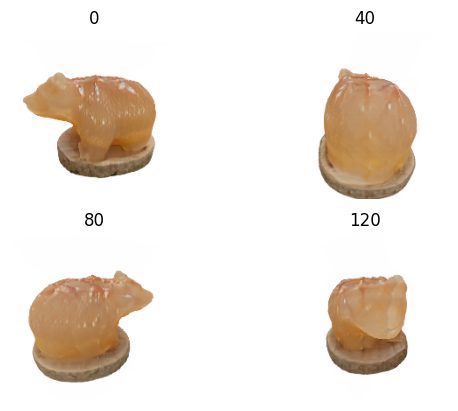

In [59]:
# визуализируем 4 кадра из последовательности визуализации
# можно заменить в этой ячейке images на depths и weights
plot_grid(images, range(0, 160, 40))

In [60]:
inferrer.images_to_video(images, "./result.mov", fps=40)
_ = results["mesh"].export('result.ply', 'ply') # return _ to omit output from printing

[mpeg4 @ 0x5a44b00] too many threads/slices (13), reducing to 12


In [62]:
import open3d as o3d
# print(o3d.__version__)
mesh = o3d.io.read_point_cloud('result.ply')
o3d.visualization.draw_geometries([mesh])

In [81]:
_ = results["mesh"].export('result.gltf', 'gltf') #

In [83]:
# mesh = o3d.io.read_point_cloud('result.gltf')
# o3d.visualization.draw_geometries([mesh])

[Open3D WARNING] Read geometry::PointCloud failed: unknown file extension for result.gltf (format: auto).
